# Low-Level Optimization Techniques

Testing and visualizing optimization techniques.

In [1]:
import matplotlib.pyplot as plt
from utils import compile, execute, decompose_results


def plot_techniques(N: list[int], techniques: dict) -> None:
    fig, ax = plt.subplots()
    for technique in techniques:
        ax.plot(N, techniques[technique], label=f"{technique}")
    ax.set(xlabel='Matrix dimension', ylabel='Duration (μs)')
    #ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend()
    plt.show()

## Cache-Based Optimization Techniques

A CPU cache is a low-latency hardware component directly attached to a CPU. When the CPU accesses
data from main memory, it writes them into the cache. When the CPU needs to access main memory
again, it first checks if the data are already in the cache. It's that the case, it retrieves data
from the cache instead of using high-latency main memory. This is called a cache hit. It accelerates
programs because the CPU does not have to waste clock cycles waiting for data to arrive from main
memory.

We can accelerate programs by writing them in a way that maximizes cache hits to reduce the time
waiting for data from main memory. The key for that is the **principle of locality**. We want to use
the data in the cache before accessing the main memory again, and that can be accomplished by
accessing data that sit in the same block of memory.

An algorithm is called **cache-aware** if it is optimized by knowing the size of the cache. It is
called **cache-oblivious** if it is optimized for the cache regardless of its size. The thesis
https://ocw.mit.edu/courses/6-895-theory-of-parallel-systems-sma-5509-fall-2003/6dc7de52dcf13b53cebf2fe10ae6752a_cach_oblvs_thsis.pdf
explains it in detail.

### Cache-Oblivious Matrix Multiplication

Matrix multiplication is really "baby's first cache optimization". We can accelerate a naïve matrix
multiplication by transposing the right-hand matrix and access its rows instead of columns, which
results in fewer cache misses. But a truly cache-oblivious algorithm can be achieved by recursively
performing multiplication and additions.

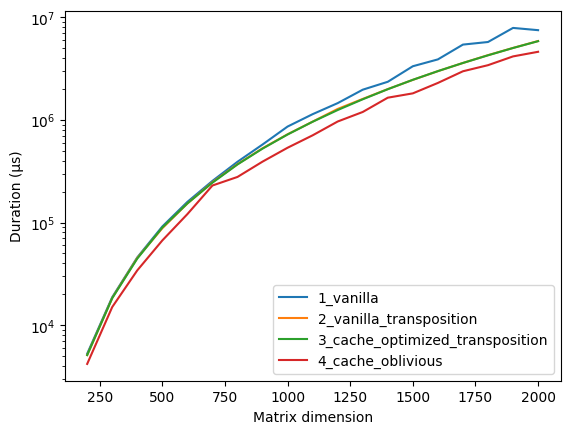

In [24]:
executable = compile("cache/matrix_multiplication")
output = execute(executable)
N, result = decompose_results(output)
plot_techniques(N, result)

Notice:

- The naïve implementation (`1_vanilla`) is the slowest one because of all the cache misses.
- Transposition (`2_vanilla_transposition`) accelerates computations.
- Cache-oblivious transposition (`3_cache_optimized_transposition`) does not provide much benefit
  compared to naïve transposition. It should be faster in theory because it reduces cache misses,
  but the compiler probably has an easier time optimizing the simpler version, which makes it faster
  in practice.
- Cache-oblivious matrix multiplication (`4_cache_oblivious`) is faster because it basically
  combines transposition and multiplication / addition, which reduces cache misses even further.

In [25]:
A = result["1_vanilla"][-1]
B = result["2_vanilla_transposition"][-1]
D = result["4_cache_oblivious"][-1]
print(f"The transposition-based algorithm completed in {B / A * 100:.5} % of the time taken by the naïve implementation.")
print(f"The cache-oblivious algorithm completed in {D / A * 100:.5} % of the time taken by the naïve implementation.")

The transposition-based algorithm completed in 78.361 % of the time taken by the naïve implementation.
The cache-oblivious algorithm completed in 61.574 % of the time taken by the naïve implementation.
